In [1]:
# Constants
DATA_PATH   = "../data/processed/1_preprocessed_df.pkl"

x_train_export_path = "../data/processed/3_x_train.pkl"
y_train_export_path = "../data/processed/3_y_train_label.pkl"
x_test_export_path = "../data/processed/3_x_test.pkl"
y_test_export_path = "../data/processed/3_y_test_label.pkl"

In [2]:
# Load packages
import pandas as pd 
import numpy as np

from pathlib import Path
import logging
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

In [3]:
# Load dataset and make a copy
raw_df = pd.read_pickle(DATA_PATH)
df = raw_df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   country         100000 non-null  object        
 1   product         100000 non-null  object        
 2   salesPerWeek    100000 non-null  int64         
 3   regular_price   100000 non-null  float64       
 4   current_price   100000 non-null  float64       
 5   ratio           100000 non-null  float64       
 6   retailweek      100000 non-null  datetime64[ns]
 7   promo1          100000 non-null  int64         
 8   promo2          100000 non-null  int64         
 9   customer_id     100000 non-null  float64       
 10  product.1       100000 non-null  object        
 11  productgroup    100000 non-null  object        
 12  category        100000 non-null  object        
 13  cost            100000 non-null  float64       
 14  style           100000 non-null  obje

In [5]:
# create list for numerical and categorical columns 
cat_cols = list(raw_df.select_dtypes(include=['object']).columns)
num_cols = list(raw_df.select_dtypes(exclude=['object']).columns)

## 1-Create a Test set
- **Create a test set before feature engineering to avoid data leakage**
- **Use stratified sampling to ensure the test set is representative of the whole dataset and to avoid sampling bias**

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits =1, test_size =0.2, random_state=42)
for train_index, test_index in split.split(df,df['product.1']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [7]:
x_train = strat_train_set.drop("label",axis=1)
y_train = strat_train_set['label'].copy()
x_test = strat_test_set.drop("label",axis=1)
y_test = strat_test_set['label'].copy()

## 2-Feature Selection

In [8]:
cat_cols

['country',
 'product',
 'product.1',
 'productgroup',
 'category',
 'style',
 'sizes',
 'gender',
 'hex_main',
 'hex_sec',
 'month_year']

In [9]:
num_cols

['salesPerWeek',
 'regular_price',
 'current_price',
 'ratio',
 'retailweek',
 'promo1',
 'promo2',
 'customer_id',
 'cost',
 'rgb_r_main_col',
 'rgb_g_main_col',
 'rgb_b_main_col',
 'rgb_r_sec_col',
 'rgb_g_sec_col',
 'rgb_b_sec_col',
 'label',
 'discount',
 'profit',
 'day',
 'month',
 'year',
 'prices_diff']

- **Features to Drop:**
    - **product feature will introduce a dimensionality problem if converted to categorical**
    - **product.1 as it contain 10 values everyone has 10k instances, not needed**
    - **regular price, current_price as we drived new better features: prices_diff and profit**
    - **ratio, as we drived new feature Discount**
    - **retailweek and day as we have more representative features month, year, month_year**
    - **Customer_id will introduce curse of dimensionality**
    - **rgb_main and rgb_sec 6 columns, as we derived two columns hex_main and hex_sec**

In [10]:
# Drop Features
drop_cols = ['product','product.1','regular_price','current_price','ratio','retailweek','customer_id','rgb_r_main_col',
                         'rgb_g_main_col', 'rgb_b_main_col','rgb_r_sec_col','rgb_g_sec_col','rgb_b_sec_col','day']
x_train = x_train.drop(columns=drop_cols)

In [25]:
# create pipeline for numerical attributes, added simpleimputer to impute missing data in case of new data that has missing values.
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())
 
# create pipeline for categorical attributes                            
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                               OneHotEncoder(handle_unknown = "ignore"))

# Combine both num and cate pipeline using column transformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, x_num_cols),
    ("cat", cat_pipeline, x_cat_cols),
    ])


In [26]:
# apply all transformations
x_train_pipe = full_pipeline.fit_transform(x_train)
x_train_pipe

<80000x73 sparse matrix of type '<class 'numpy.float64'>'
	with 1440000 stored elements in Compressed Sparse Row format>

In [27]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_pipe, y_train)

RandomForestClassifier()

In [32]:
# view the feature scores
feature_scores = pd.Series(rf_clf.feature_importances_, index=full_pipeline.get_feature_names_out()).sort_values(ascending=False)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the feature scores
print(feature_scores)

num__discount                            0.2581
num__profit                              0.1631
num__salesPerWeek                        0.1542
num__prices_diff                         0.1439
num__month                               0.0379
cat__country_Germany                     0.0178
cat__country_Austria                     0.0176
num__year                                0.0151
cat__country_France                      0.0125
num__cost                                0.0100
num__promo1                              0.0084
cat__month_year_Aug 2015                 0.0070
cat__month_year_Jul 2016                 0.0066
cat__month_year_Jan 2016                 0.0056
cat__month_year_Jul 2015                 0.0051
cat__month_year_Feb 2015                 0.0049
cat__month_year_Aug 2016                 0.0047
cat__month_year_Feb 2016                 0.0047
cat__month_year_Jan 2017                 0.0046
cat__month_year_Jan 2015                 0.0045
cat__month_year_Mar 2015                

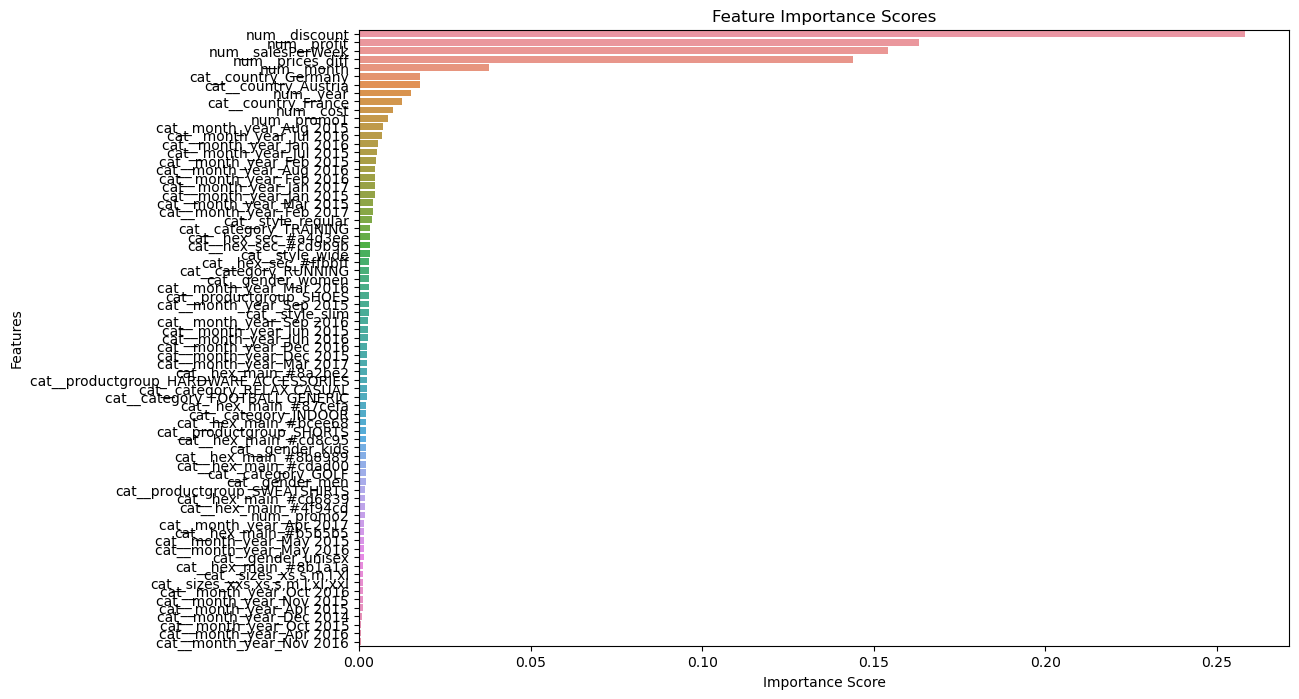

In [33]:
# Sort the feature scores in descending order
feature_scores = feature_scores.sort_values(ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_scores.values, y=feature_scores.index)
plt.title('Feature Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 3-Handling categorical attributes

In [11]:
# create list of categorical and numerical columns
x_cat_cols = list(x_train.select_dtypes(include=['object']).columns)
x_num_cols = list(x_train.select_dtypes(exclude=['object']).columns)

In [12]:
x_cat_cols

['country',
 'productgroup',
 'category',
 'style',
 'sizes',
 'gender',
 'hex_main',
 'hex_sec',
 'month_year']

### Using One-hot encoding 

In [13]:
# Implement one hot encoding using pd.get_dummies()
x_train_one_hot =pd.get_dummies(x_train)

In [14]:
x_train_one_hot

,salesPerWeek,promo1,promo2,cost,discount,profit,month,year,prices_diff,country_Austria,country_France,country_Germany,productgroup_HARDWARE ACCESSORIES,productgroup_SHOES,productgroup_SHORTS,productgroup_SWEATSHIRTS,category_FOOTBALL GENERIC,category_GOLF,category_INDOOR,category_RELAX CASUAL,category_RUNNING,category_TRAINING,style_regular,style_slim,style_wide,"sizes_xs,s,m,l,xl","sizes_xxs,xs,s,m,l,xl,xxl",gender_kids,gender_men,gender_unisex,gender_women,hex_main_#4f94cd,hex_main_#87cefa,hex_main_#8a2be2,hex_main_#8b1a1a,hex_main_#8b8989,hex_main_#b5b5b5,hex_main_#bcee68,hex_main_#cd6839,hex_main_#cd8c95,hex_main_#cdad00,hex_sec_#a4d3ee,hex_sec_#cd9b9b,hex_sec_#ffbbff,month_year_Apr 2015,month_year_Apr 2016,month_year_Apr 2017,month_year_Aug 2015,month_year_Aug 2016,month_year_Dec 2014,month_year_Dec 2015,month_year_Dec 2016,month_year_Feb 2015,month_year_Feb 2016,month_year_Feb 2017,month_year_Jan 2015,month_year_Jan 2016,month_year_Jan 2017,month_year_Jul 2015,month_year_Jul 2016,month_year_Jun 2015,month_year_Jun 2016,month_year_Mar 2015,month_year_Mar 2016,month_year_Mar 2017,month_year_May 2015,month_year_May 2016,month_year_Nov 2015,month_year_Nov 2016,month_year_Oct 2015,month_year_Oct 2016,month_year_Sep 2015,month_year_Sep 2016
59582,4,0,0,1.70,0.302172,35.25,9,2015,16.0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
85097,28,0,0,5.20,0.259740,14.75,8,2015,7.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31019,135,1,0,8.70,0.643623,6.25,12,2016,27.0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39585,25,0,0,4.20,0.291971,29.75,2,2017,14.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19980,345,1,0,13.29,0.200501,2.66,8,2016,4.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27560,111,1,0,13.29,0.492454,18.66,12,2015,31.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30891,7,0,0,2.29,0.233918,56.66,1,2015,18.0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19369,13,0,0,8.70,0.190552,93.25,2,2017,24.0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40925,156,0,0,4.20,0.122574,38.75,1,2016,6.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 4-Feature Scaling and Transformation

In [15]:
x_num_cols

['salesPerWeek',
 'promo1',
 'promo2',
 'cost',
 'discount',
 'profit',
 'month',
 'year',
 'prices_diff']

- **Scale the Feature using Standard Scaler**

In [16]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
x_train_one_hot_scaled = std_scaler.fit_transform(x_train_one_hot)

In [17]:
x_train_one_hot_scaled

array([[-0.60119002, -0.25540586, -0.06972098, ..., -0.19915609,
         5.34248046, -0.18137749],
       [-0.32694652, -0.25540586, -0.06972098, ..., -0.19915609,
        -0.18717897, -0.18137749],
       [ 0.89572239,  3.91533693, -0.06972098, ..., -0.19915609,
        -0.18717897, -0.18137749],
       ...,
       [-0.49834871, -0.25540586, -0.06972098, ..., -0.19915609,
        -0.18717897, -0.18137749],
       [ 1.13568545, -0.25540586, -0.06972098, ..., -0.19915609,
        -0.18717897, -0.18137749],
       [-0.33837334, -0.25540586, -0.06972098, ..., -0.19915609,
        -0.18717897, -0.18137749]])

- **Things to try next:**
    - **We have 3 columns with heavy tail distribution 'salesperWeek', ' profit', 'price_diff'**
    - **we have to shrink the heavy tail before we scale the features to make the distribution roughly symmetrical.**
    - **we can replace the feature with its logarithm, but that introduce new problems , we have values of 0 in those features and log(0) = undefined, so it will produce NAN values**
    - **So we have to either change these values to (-0.1,0.1) or to impute the NAN values it produced**

- **It is better to encode the `style` column using the ordinal encoder because values `slim, regular, wide` have a natural ordered relationship.**

- **Also We need to write functions for all data transformations we applied So we can easily prepare the data the next time, and to apply these transformations easily to the test data**

# Export Data

In [35]:
# Export Data
x_train.to_pickle(x_train_export_path)
y_train.to_pickle(y_train_export_path)
x_test.to_pickle(x_test_export_path)
y_test.to_pickle(y_test_export_path)